In [14]:
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(invalid='ignore')  # Specifically suppress NumPy divide-by-invalid warnings

from sklearn.ensemble import RandomForestRegressor


In [16]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv("cleaned_tonometry_dataset.csv")

# Features and target
X = df.drop(columns=["Age", "patient_id"], errors='ignore')
y = df["Age"]

# Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), X.columns)
], remainder="drop")

# Base Random Forest Regressor
rf_base = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

# Full pipeline
pipe_inner = Pipeline([
    ("prep", preprocess),
    ("reg", rf_base)
])

# Hyperparameter grid
param_grid = {
    "reg__n_estimators": [200, 400],
    "reg__max_depth": [None, 10],
    "reg__min_samples_split": [2, 4],
    "reg__min_samples_leaf": [1, 2],
    "reg__max_features": ["sqrt"],
    "reg__bootstrap": [True],
}

# Nested CV
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_inner,
    param_grid=param_grid,
    cv=inner_cv,
    scoring="neg_mean_absolute_error",
    refit=True,
    n_jobs=-1,
    verbose=0
)

cv_results = cross_validate(
    estimator=grid,
    X=X, y=y,
    cv=outer_cv,
    scoring={"MAE": make_scorer(mean_absolute_error)},
    return_estimator=True,
    n_jobs=-1,
    verbose=0
)

print(f"Best Outer-CV MAE: {-cv_results['test_MAE'].mean():.2f}")
best_idx = np.argmin(cv_results["test_MAE"])
best_params = cv_results["estimator"][best_idx].best_params_
print("Best Parameters:")
for k, v in best_params.items():
    print(f"  {k} = {v}")

# Final model training
best_rf_params = {k.replace("reg__", ""): v for k, v in best_params.items()}
preprocess_final = preprocess.fit(X)
X_all_proc = preprocess_final.transform(X)

rf_final = RandomForestRegressor(
    **best_rf_params, random_state=42, n_jobs=-1, oob_score=True
)
rf_final.fit(X_all_proc, y)

oob_mae = mean_absolute_error(y, rf_final.oob_prediction_)
print(f"OOB MAE: {oob_mae:.2f}")

final_model = make_pipeline(preprocess_final, rf_final)
joblib.dump(final_model, "final_tonometry_model_rf_best.pkl")
print("✓ Saved model → final_tonometry_model_rf_best.pkl")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Best Outer-CV MAE: -8.61
Best Parameters:
  reg__bootstrap = True
  reg__max_depth = None
  reg__max_features = sqrt
  reg__min_samples_leaf = 2
  reg__min_samples_split = 2
  reg__n_estimators = 400
OOB MAE: 8.71
✓ Saved model → final_tonometry_model_rf_best.pkl


In [18]:
import joblib

# Load the trained pipeline (preprocessing + model)
model = joblib.load("final_tonometry_model_rf_best.pkl")


In [20]:
# Predict on full data
y_pred = model.predict(X)

from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Final MAE: {mae:.2f}")
print(f"Final R² Score: {r2:.2f}")


Final MAE: 4.05
Final R² Score: 0.83


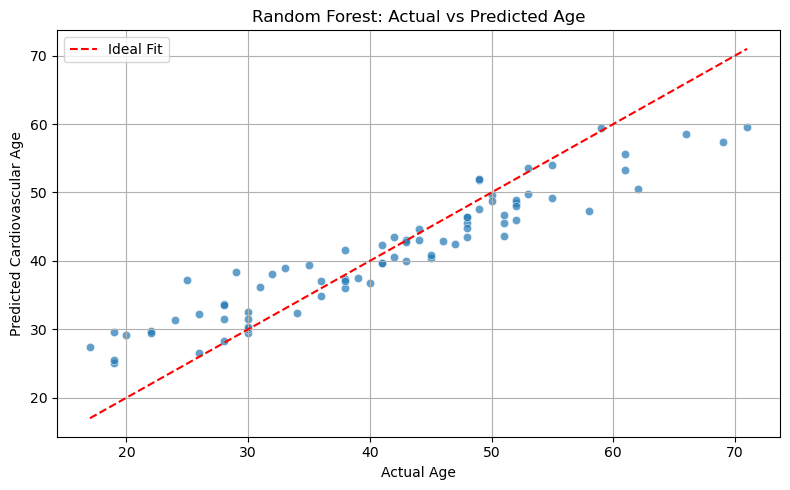

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Cardiovascular Age")
plt.title("Random Forest: Actual vs Predicted Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


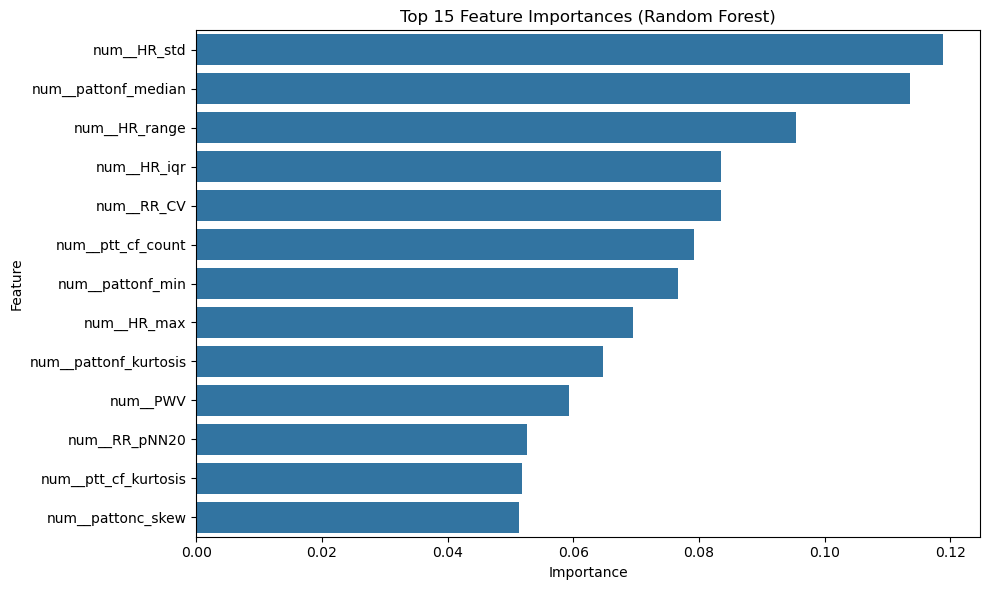

In [24]:
# Access the RandomForestRegressor from the pipeline
rf_model = model.named_steps["randomforestregressor"]

# Access feature names after preprocessing
feature_names = model.named_steps["columntransformer"].get_feature_names_out()

import pandas as pd

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
